In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic=True
torch.set_printoptions(sci_mode=False)

import time
from tqdm.notebook import tqdm

In [ ]:
# `transforms` is used to apply augmentation techniques and modification to the image data (e.g, rotate, resize, normalization, etc.).
# for this one, let's just convert the image arrays to tensor.
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [ ]:
# 50,000 for training and 10,000 for validation
train_set, val_set = torch.utils.data.random_split(train_data, [50_000, 10_000])

In [ ]:
# function to set the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

In [ ]:
set_seed(143)

batch_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
set_seed(143)
images, labels = iter(train_loader).__next__()

def display_image(batch):
    batch = batch.detach().numpy()
    fig, axs = plt.subplots(1, len(batch), figsize=(12, 2))
    for i in range(len(batch)):
        axs[i].imshow(batch[i, 0, :, :], vmin=0, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()

In [ ]:
# use this function to calculate the output shape of a convolution or a pooling layer.
def calc_out(w, f, s, p):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    print(f'Output Shape: {(w - f + 2 * p) // s + 1}')

In [ ]:
images, labels = iter(train_loader).__next__()

#### Example Architecture No.2

![Architecture](https://github.com/JhunBrian/DS-413/blob/main/02%20Application%20of%20Deep%20Learning/Convolutional%20Neural%20Networks/figures/example2.drawio.png?raw=true)

#### Input Images

In [ ]:
# shape, channel, raw values are raw.

# torch.Size([batch_size, channels, height, width])
display_image(images)
print(images.shape) # batch_size, channel, height, width

#### First Convolution

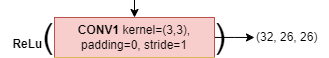

In [ ]:
# let's calculate the output shape of our input image (28,28) after the first convolution with the given parameters in CONV1.

calc_out(28, 3, 1, 0) # 28: input width/height, 3: kernel, 1: stride, 0: padding

In [ ]:
# the output shape according to the formula is a 26 by 26 image, let's try on creating a Conv2d object to assess if this is True.
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=0)

# let's also apply the ReLu activation function for the first convolution layer.
x = F.relu(conv1(images))

display_image(x)
print(x.shape)  # batch_size, channel, height, width
# It is indeed 26 x 26, but now, we have increased the `channels` for every instance to 32

#### 1st MaxPooling Layer

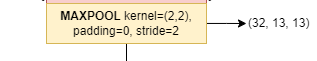

In [ ]:
# the snipped image above shows that the image size decreased after the maxpooling layer, it is now 13 by 13, let's calculate.
# 26 is the shape after the first convolution.

calc_out(26, 2, 2, 0) # 26: input width/height, 2: kernel, 2: stride, 0: padding

In [ ]:
x = F.max_pool2d(x, kernel_size=(2,2), stride=2, padding=0)

display_image(x)
print(x.shape)  # batch_size, channel, height, width
# It is indeed a 13 x 13.

#### 2nd Convolution

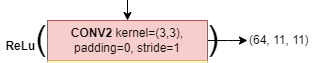

In [ ]:
# the size 11 x 11 is the output shape after the 2nd convolution. Let's try to calculate if it is 11x11.
# 13 is the shape after the first max pooling.
calc_out(13, 3, 1, 0) # 13: input height/wicth, 3: kernel, 1: stride, 0: padding

In [ ]:
# now let's implement.
# observe that our input channel is 32 and output channels is 64, this means that after the second convolution, each instance will have
# 64 channels from the original 32 channels from the previous maxpooling and convolution layers.

conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=0)
x = F.relu(conv2(x))

display_image(x)
print(x.shape)  # batch_size, channel, height, width
# It is indeed an 11 x 11.

#### 2nd MaxPooling

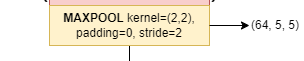

In [ ]:
# Using the defined parameters for kernel, padding and stride for the second convolution, it will output a 5x5 image data.
# let's calculate, again.

# 11 is from the previous shape
calc_out(11, 2, 2, 0)# 11: input height/wicth, 2: kernel, 2: stride, 0: padding

In [ ]:
# let's implement the second maxpooling and see if it is indeed a 5x5 output.

x = F.max_pool2d(x, kernel_size=(2,2), stride=2, padding=0)

display_image(x)
print(x.shape)  # batch_size, channel, height, width
# It is indeed a 5x5.

#### Fully Connected Layer

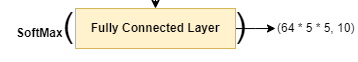

In [ ]:
# the last layer gave us 64 output channels, therefore, each instance now have 64 channels, since the previous procedure outputted
# a 5x5 image, therefore we now have (64, 5 by 5) images with 10 images in every batch.
# A fully connected layer is a flattened version of the images, so we need to reshape our image into (64*5*5, 10). 
# and apply the softmax activation.

flat = x.view(-1, 64*5*5)
flat.shape

In [ ]:
# since we only have one layer for a fully connected layer for this demo, we shall directly reduce the flattened features into 
# the number of classes which is 10.

fcn1 = nn.Linear(64*5*5, 10)

out = F.softmax(fcn1(flat), dim=1)
out.shape

#### Now let's put it all together!

![Architecture](https://github.com/JhunBrian/DS-413/blob/main/02%20Application%20of%20Deep%20Learning/Convolutional%20Neural%20Networks/figures/example2.drawio.png?raw=true)

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        self.fcn1 = nn.Linear(in_features=64*5*5, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.view(-1, 64*5*5) # flatten
        x = F.softmax(self.fcn1(x), dim=1)
        
        return x

In [ ]:
model = NN()
model

#### It vorked!

In [ ]:
# it works when you feed a single batch to the model and it returns the (instance x class)
model(images)

In [ ]:
model(images).shape # instance by class